In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
import tensorflow_hub as hub

In [3]:
data = pd.read_csv('wine-reviews.csv')

In [4]:
data.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [5]:
df = pd.read_csv('wine-reviews.csv', usecols=['country','description','points','price','variety','winery'])

In [6]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [7]:
# trying to predict points off description

df = df.dropna(subset=['description','points'])

In [8]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


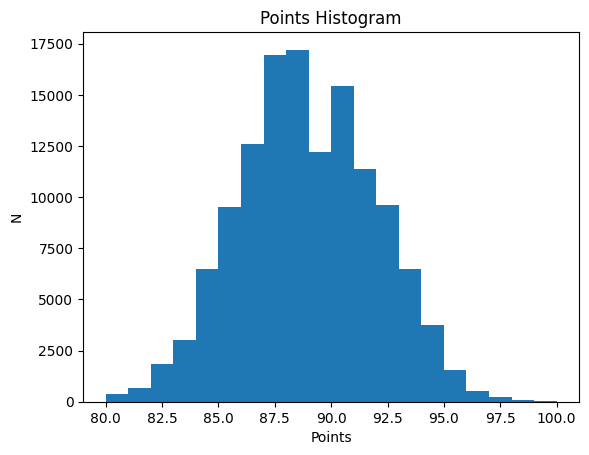

In [9]:
# to view distribution of the points

plt.hist(df.points, bins=20)
plt.title('Points Histogram')
plt.ylabel('N')
plt.xlabel('Points')
plt.show()

In [10]:
# splitting points into 2 categories based on distribution

df['label'] = (df.points >= 90).astype(int)
df = df[['description', 'label']]

### splitting into the training, validation and test datasets

In [11]:
# splitting ratio is 80:10:10

train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

In [12]:
len(train), len(val), len(test)

(103976, 12997, 12998)

In [13]:
#function sample obtained from tensorflow (https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers)
# this function helps to shuffle the data and batch it. prefetching helps in optimizing
# batch size increased cos of dataset size

def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df['description']
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [14]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

## Embedding + Model

In [15]:
embedding = 'https://tfhub.dev/google/nnlm-en-dim50/2'
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

# converts text into numbers interpretable by the model

In [17]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.16676655, -0.35446182,  0.2440248 , ..., -0.12471523,
        -0.21512213,  0.0377118 ],
       [ 0.3853199 , -0.41762173, -0.00517916, ..., -0.13291419,
        -0.02118109, -0.20583735],
       [ 0.5115765 , -0.24955961, -0.13869694, ..., -0.1568957 ,
         0.12262542, -0.33495125],
       ...,
       [ 0.50955   , -0.14326486,  0.03084221, ...,  0.10467009,
        -0.11960048,  0.26382172],
       [ 0.5834708 , -0.17612064, -0.17130864, ...,  0.04202135,
        -0.03762183, -0.0147351 ],
       [ 0.41623282, -0.37789634,  0.0351241 , ..., -0.11600515,
        -0.1288311 , -0.13190056]], dtype=float32)>

In [18]:
# building model:

model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [19]:
# compile the model

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
    loss=tf.keras.losses.BinaryCrossentropy(), # used here since its binary classification
    metrics=['accuracy']
)

In [20]:
model.evaluate(train_data)

102/102 [==============================] - 4s 20ms/step - loss: 0.6800 - accuracy: 0.5983


[0.679997444152832, 0.5982726812362671]

In [21]:
model.evaluate(valid_data)

13/13 [==============================] - 0s 20ms/step - loss: 0.6788 - accuracy: 0.6069


[0.6788429021835327, 0.6069092750549316]

In [22]:
history = model.fit(train_data, epochs=10, validation_data=valid_data)

Epoch 1/10
102/102 [==============================] - 63s 603ms/step - loss: 0.5357 - accuracy: 0.7288 - val_loss: 0.4162 - val_accuracy: 0.8030
Epoch 2/10
102/102 [==============================] - 62s 610ms/step - loss: 0.3707 - accuracy: 0.8313 - val_loss: 0.3814 - val_accuracy: 0.8226
Epoch 3/10
102/102 [==============================] - 61s 596ms/step - loss: 0.3271 - accuracy: 0.8552 - val_loss: 0.3700 - val_accuracy: 0.8299
Epoch 4/10
102/102 [==============================] - 61s 601ms/step - loss: 0.3015 - accuracy: 0.8686 - val_loss: 0.3712 - val_accuracy: 0.8290
Epoch 5/10
102/102 [==============================] - 62s 604ms/step - loss: 0.2808 - accuracy: 0.8805 - val_loss: 0.3750 - val_accuracy: 0.8296
Epoch 6/10
102/102 [==============================] - 61s 600ms/step - loss: 0.2618 - accuracy: 0.8896 - val_loss: 0.3812 - val_accuracy: 0.8313
Epoch 7/10
102/102 [==============================] - 61s 591ms/step - loss: 0.2447 - accuracy: 0.8980 - val_loss: 0.3920 - val_ac

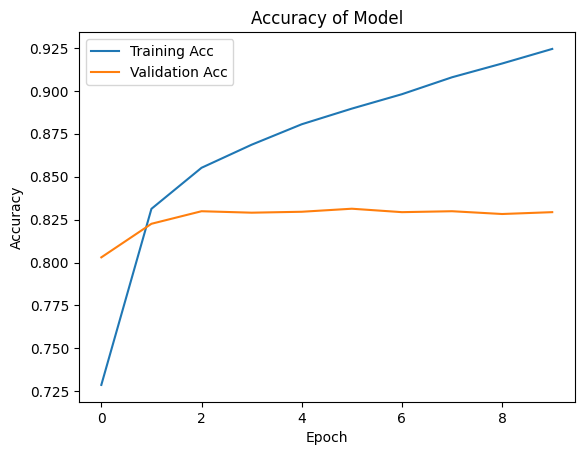

In [23]:
# the above results show the validation loss increasing towards the last epochs, indicating overfitting issue
# to visualize this:

plt.plot(history.history['accuracy'], label='Training Acc')
plt.plot(history.history['val_accuracy'], label='Validation Acc')
plt.title('Accuracy of Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

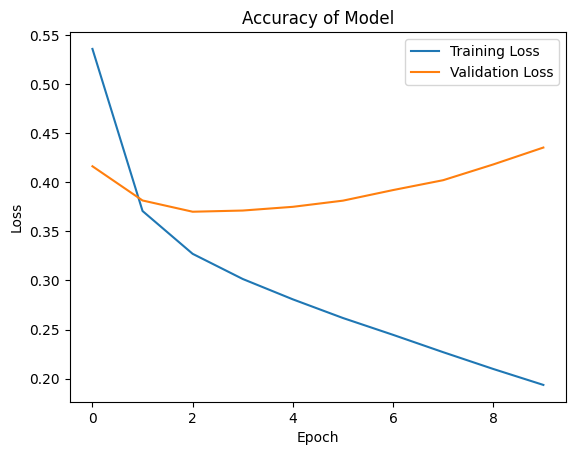

In [24]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Accuracy of Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [25]:
# fixing the overfitting using 'dropout':

model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [26]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
    loss=tf.keras.losses.BinaryCrossentropy(), # used here since its binary classification
    metrics=['accuracy']
)

In [27]:
model.evaluate(train_data)

102/102 [==============================] - 13s 118ms/step - loss: 0.7449 - accuracy: 0.3779


[0.7449064254760742, 0.37786605954170227]

In [28]:
model.evaluate(valid_data)

13/13 [==============================] - 2s 116ms/step - loss: 0.7487 - accuracy: 0.3683


[0.7486579418182373, 0.36831575632095337]

In [29]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 60s 575ms/step - loss: 0.6137 - accuracy: 0.6532 - val_loss: 0.4430 - val_accuracy: 0.8080
Epoch 2/5
102/102 [==============================] - 56s 548ms/step - loss: 0.4055 - accuracy: 0.8281 - val_loss: 0.3828 - val_accuracy: 0.8237
Epoch 3/5
102/102 [==============================] - 57s 559ms/step - loss: 0.3452 - accuracy: 0.8614 - val_loss: 0.3863 - val_accuracy: 0.8237
Epoch 4/5
102/102 [==============================] - 59s 574ms/step - loss: 0.3191 - accuracy: 0.8715 - val_loss: 0.3969 - val_accuracy: 0.8240
Epoch 5/5
102/102 [==============================] - 55s 534ms/step - loss: 0.3003 - accuracy: 0.8820 - val_loss: 0.4052 - val_accuracy: 0.8236


In [30]:
model.evaluate(test_data)

13/13 [==============================] - 1s 89ms/step - loss: 0.3956 - accuracy: 0.8258


[0.39557942748069763, 0.8258193731307983]